# 2. Nodes' Contribution (Q2)
---
## 1) Implement a function analyze_centrality(flight_network, airport) that computes the following centrality measures for a given airport:

- Betweenness centrality: Measures how often a node appears on the shortest paths between other nodes.
- Closeness centrality: Measures how easily a node can access all other nodes in the network.
- Degree centrality: Simply counts the number of direct connections to the node.
- PageRank: Computes the "importance" of a node based on incoming connections and their weights.



In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from collections import defaultdict
from heapq import heappop, heappush
from functions_Q2 import * 

df = pd.read_csv('Airports2.csv')

In [2]:
conflicting_distances = (
    df.groupby(["Origin_airport", "Destination_airport"])["Distance"]
    .nunique()
    .reset_index()
)

# Filter groups where the number of unique distances is greater than 1
conflicts = conflicting_distances[conflicting_distances["Distance"] > 1]

# Show the result
print(conflicts)

      Origin_airport Destination_airport  Distance
30               ABE                 CLT         2
51               ABE                 GSP         2
70               ABE                 LEX         2
128              ABI                 AUS         3
195              ABQ                 AUS         3
...              ...                 ...       ...
36208            YIP                 BFR         2
36229            YIP                 BWI         2
36365            YIP                 LEX         2
36378            YIP                 MCI         2
36382            YIP                 MDW         2

[1613 rows x 3 columns]


This dataset contains multiple distances for the same origin and destination airports so we need to take the mean of those values to assign a weight to those edges.

In [3]:
# just to show an example of this problem
print(df['Distance'].loc[(df['Origin_airport'] == "ABE") & (df['Destination_airport'] == "CLT") ])

# we will aggreagate by taking the mean of the distance
data = df.groupby(['Origin_airport', 'Destination_airport']).agg({'Distance': 'mean'}).reset_index() 

# we will also delite all the rows that have the same starting and ending airports
data = data.loc[data['Distance'] != 0]

1980810    480
1980812    480
1980824    480
1980825    480
1980826    480
          ... 
2059076    481
2059077    481
2059078    481
2059088    481
2059248    481
Name: Distance, Length: 565, dtype: int64


In [4]:
# We can now create the Directed Graph, this graph will not be a Strongly Connected Graph as not every node
# in the graph is reacheable from every other
Data_Graph = nx.DiGraph()
for _, row in data.iterrows():
    origin = row['Origin_airport']
    destination = row['Destination_airport']
    weight = int(row['Distance'])
    Data_Graph.add_edge(origin, destination, weight=weight)

#just to show this:
print(f"Is this a SCC graph?: {nx.is_strongly_connected(Data_Graph)}")


Is this a SCC graph?: False


To compute the centrality measure required without implementing any nx functions we need to have an adjacency matrix( in this case a list) and teh collections of all the shortest paths and distances:

In [5]:
#Since the adjacency matrix would be very sparse, we will instead conpute an adjacency list

adjacency_list = {node: [] for node in Data_Graph.nodes} # we can initialize a dictionary

for edge in Data_Graph.edges: #iterate over all the edges in the graph

    source, target = edge
    adjacency_list[source].append(target)  #add the connections for each source node


In [6]:
#we will then use our own function to compute the shortest paths from each node to all the others and 
# all the shortest distances

all_paths, all_distances = all_shortest_paths(Data_Graph)

### A short introduction for all these measures:

1) betweenness centrality: 

The betweenness centrality of a node $ v $ is given by the expression:

$
g(v) = \sum_{s \neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}
$

where $ \sigma_{st} $ is the total number of shortest paths from node $ s $ to node $ t $ and $ \sigma_{st}(v) $ is the number of those paths that pass through $ v $ (not where $ v $ is an endpoint).

---
(...) Therefore, the calculation may be rescaled by dividing through by the number of pairs of nodes not including $ v $, so that $ g \in [0, 1] $. The division is done by $ (N-1)(N-2) $ for directed graphs and $ \frac{(N-1)(N-2)}{2} $ for undirected graphs, where $ N $ is the number of nodes in the **giant component**.

*Source Wikipedia*

2) closeness centrality: 

Here we must remember that this centrality measures work for connected graph, so the definition we want to look at is this:

When a graph is not **strongly connected**, Beauchamp introduced in 1965 the idea of using the sum of reciprocal of distances, instead of the reciprocal of the sum of distances, with the convention:

$
\frac{1}{\infty} = 0
$

The formula is given as:

$
H(x) = \sum_{y \neq x} \frac{n - 1}{d(y, x)}.
$

*Source Wikipedia*

3) in-degree centrality: 

The in-degree centrality for a node v is the fraction of nodes its incoming edges are connected to.
The degree centrality values are normalized by dividing by the maximum possible degree in a simple graph n-1 where n is the number of nodes in G.

*Source Networkx packet's documentation*

4) PageRank:

The PageRank algorithm outputs a probability distribution used to represent the likelihood that a person randomly clicking on links will arrive at any particular page. PageRank can be calculated for collections of documents of any size. It is assumed in several research papers that the distribution is evenly divided among all documents in the collection at the beginning of the computational process. The PageRank computations require several passes, called "iterations", through the collection to adjust approximate PageRank values to more closely reflect the theoretical true value.

A probability is expressed as a numeric value between 0 and 1. A 0.5 probability is commonly expressed as a "50% chance" of something happening. Hence, a document with a PageRank of 0.5 means there is a 50% chance that a person clicking on a random link will be directed to said document.

*Source Wikipedia*


Now we have all we need to compute the centrality measures.

In [7]:

def analyze_centrality(graph, airport, all_paths, all_distances, adjacency_list):
    
    betweenness_centrality_scores = betweenness_centrality(Data_Graph, all_paths)

    closeness_scores = closeness_centrality(all_distances)

    in_degree_centrality = in_degree_centrality_adj(adjacency_list)

    pagerank_scores = compute_pagerank(Data_Graph, adjacency_list)

    final_scores = {
    "Betweenness Centrality" : betweenness_centrality_scores,
    "Closeness Centrality" : closeness_scores,
    "In-Degree Centrality" : in_degree_centrality,
    "PageRank Score" : pagerank_scores
    }

    for metric, scores in final_scores.items():
        print(f"The {metric} for Airport {airport} is: {scores[airport]:.4f}\n")
    



We can simply use this function to print the scores:

In [8]:
# as an example:
analyze_centrality(Data_Graph, "CLT", all_paths, all_distances, adjacency_list)

The Betweenness Centrality for Airport CLT is: 0.0075

The Closeness Centrality for Airport CLT is: 1.0860

The In-Degree Centrality for Airport CLT is: 0.2617

The PageRank Score for Airport CLT is: 0.0037



---
### 2) Write a function compare_centralities(flight_network) to:

- Compute and compare centrality values for all nodes in the graph.
- Plot centrality distributions (histograms for each centrality measure).
- Return the top 5 airports for each centrality measure.


In [13]:

def compare_centralities(Data_Graph, all_paths, all_distances, adjacency_list):

    final_scores = {
    "Betweenness Centrality" : betweenness_centrality(Data_Graph, all_paths),
    "Closeness Centrality" : closeness_centrality(all_distances),
    "In-Degree Centrality" : in_degree_centrality_adj(adjacency_list),
    "PageRank" : compute_pagerank(Data_Graph, adjacency_list)
    }
    
    plot_centrality_distributions(final_scores)

    top_5 = {
        metric: sorted(scores.items(), key=lambda x: x[1], reverse=True)[:5] for metric, scores in final_scores.items()
    }

    # Print top 5 nodes for each centrality measure
    for metric, top_nodes in top_5.items():
        print(f"\nTop 5 Nodes by {metric}:")
        for node, score in top_nodes:
            print(f"Node {node}: {score:.4f}")
    

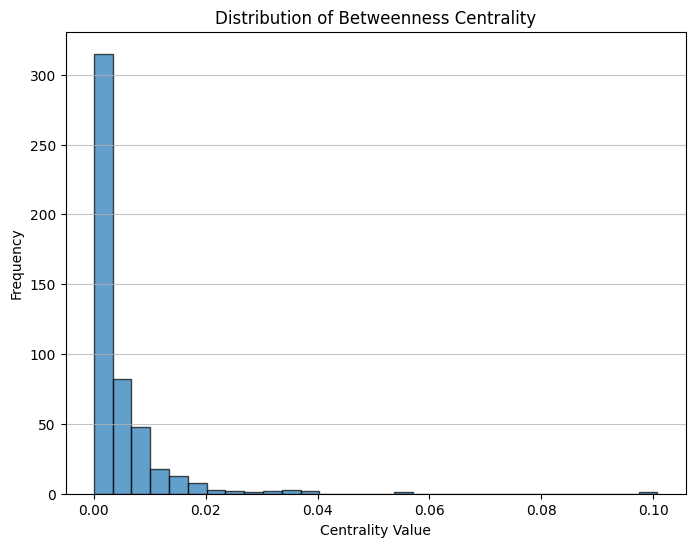

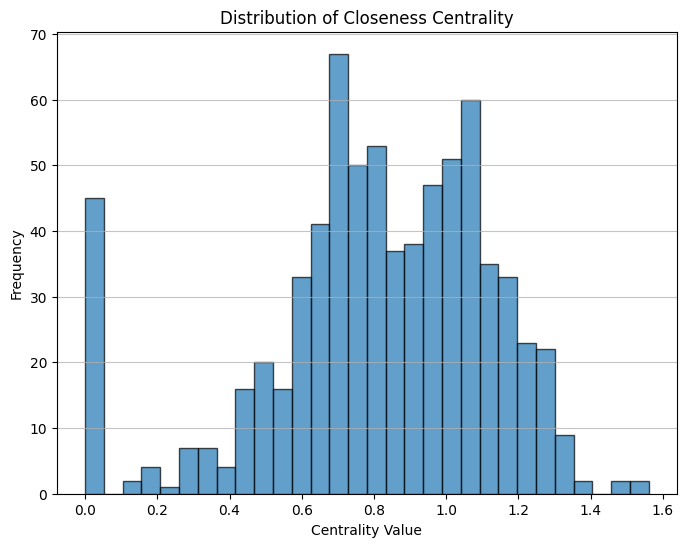

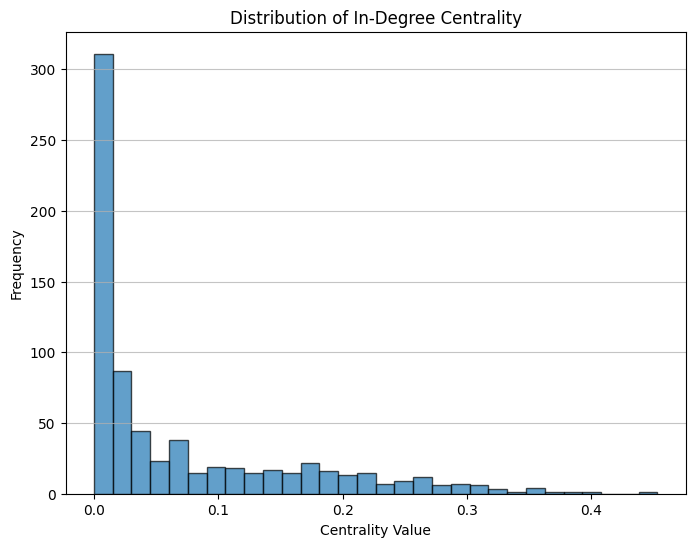

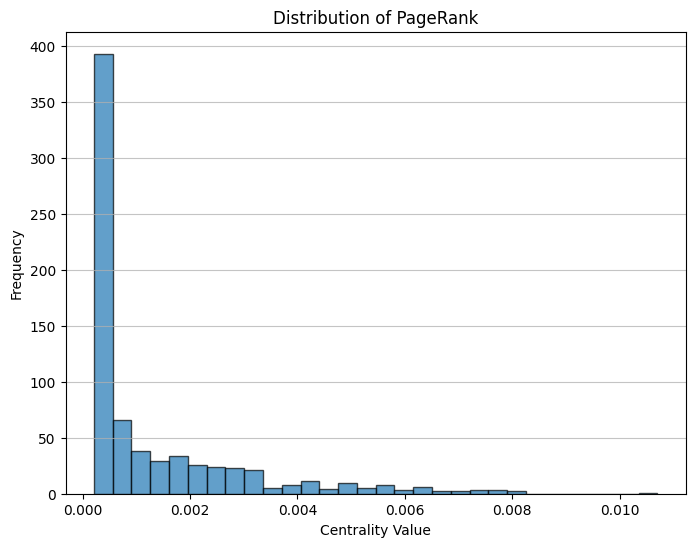


Top 5 Nodes by Betweenness Centrality:
Node YIP: 0.1008
Node MEM: 0.0542
Node DFW: 0.0389
Node MCI: 0.0375
Node LAS: 0.0361

Top 5 Nodes by Closeness Centrality:
Node JRB: 1.5610
Node JRA: 1.5253
Node YIP: 1.4728
Node DTW: 1.4589
Node MDW: 1.3870

Top 5 Nodes by In-Degree Centrality:
Node YIP: 0.4532
Node MSP: 0.3994
Node MEM: 0.3802
Node MCI: 0.3733
Node ATL: 0.3554

Top 5 Nodes by PageRank:
Node YIP: 0.0107
Node ANC: 0.0081
Node LAX: 0.0080
Node LAS: 0.0079
Node MSP: 0.0079


In [14]:
compare_centralities(Data_Graph, all_paths, all_distances, adjacency_list)

---
### 3) Ask LLM (eg. ChatGPT) to suggest alternative centrality measures that might be relevant to this task. How can you check that the results given by the LLM are trustable?

## Good Fifth Metric for a DiGraph Related to Airport Traffic

A **good fifth metric** for analyzing airport traffic in a directed graph is **Eigenvector Centrality**. This measure considers both the direct connections of a node and the importance of the nodes it is connected to. In airport networks, this metric helps identify airports that are influential because of their connections to other key hubs.

---

### Mathematical Explanation of Eigenvector Centrality

The **Eigenvector Centrality** of a node $v_i$ is given by:

$
x_i = \frac{1}{\lambda} \sum_{j \in N(i)} A_{ji} x_j
$

Where:
- $x_i$: The centrality score of node $i$.
- $\lambda$: The largest eigenvalue of the adjacency matrix $A$.
- $A_{ji}$: The entry in the adjacency matrix representing the edge weight from node $j$ to node $i$.
- $N(i)$: The set of nodes that point to $i$ (its in-neighbors).

In matrix form, this can be written as:

$
Ax = \lambda x
$

Where $x$ is the eigenvector corresponding to the largest eigenvalue $\lambda$.

---

### Why is Eigenvector Centrality Suitable for Airport Traffic?

- **Weighted Connections**: In an airport network, edge weights can represent passenger volume or flight frequency. Eigenvector Centrality emphasizes airports connected to busy hubs.
- **Indirect Influence**: It accounts for the influence of both direct and indirect connections, highlighting airports that are critical due to their links to other important hubs.


### However Eigenvector Centrality is not applicable to disconnected graphs as ours due to the fact that, in a disconnected graph, the eigenvector computation may yield zeros for some nodes that are not reachable from other parts of the graph, so we asked GPT again for a solution:

### This is the explanation we got:

### Explanation of the Solution
1) Strongly Connected Components:
    - The graph is split into its strongly connected components using nx.strongly_connected_components().
2) Per-Component Calculation:
    - Eigenvector Centrality is computed separately for each strongly connected component using nx.eigenvector_centrality_numpy().
3) Combining Results:
    - The scores from all components are combined into a single dictionary.

### Why Does This Work?
By breaking the graph into strongly connected components:
1) Eigenvector Centrality is calculated where it makes sense (within connected parts of the graph).
2) Nodes in disconnected components are handled independently.

In [67]:
def compute_eigenvector_centrality_for_disconnected(graph):
    """
    Compute Eigenvector Centrality for a disconnected graph.

    Args:
        graph (nx.DiGraph): A directed graph with weighted edges.

    Returns:
        dict: A dictionary where keys are nodes and values are their Eigenvector Centrality scores.
    """
    # Initialize the dictionary for the final scores
    eigenvector_scores = {}

    # Identify strongly connected components
    sccs = list(nx.strongly_connected_components(graph))

    # Compute Eigenvector Centrality for each SCC
    for scc in sccs:
        if len(scc) > 1:  # Only compute for components with more than one node
            subgraph = graph.subgraph(scc)
            sub_scores = nx.eigenvector_centrality_numpy(subgraph, weight='weight')
            eigenvector_scores.update(sub_scores)
        else:
            # Assign a score of 0.0 for isolated nodes
            isolated_node = list(scc)[0]
            eigenvector_scores[isolated_node] = 0.0

    return eigenvector_scores

# Compute Eigenvector Centrality for disconnected graph
eigenvector_scores = compute_eigenvector_centrality_for_disconnected(Data_Graph)

# Display results
print("Eigenvector Centrality Scores:")
for airport, score in eigenvector_scores.items():
    print(f"Airport {airport}: {score:.6f}")


Eigenvector Centrality Scores:
Airport ARB: 0.000000
Airport FCM: 0.000000
Airport AWX: 0.000000
Airport AL3: 0.000000
Airport DWH: 0.000000
Airport ESN: 0.000000
Airport FAM: 0.000000
Airport BYI: 0.000000
Airport FVS: 0.000000
Airport LJY: 0.000000
Airport MIW: 0.000000
Airport RAC: 0.000000
Airport CFV: 0.000000
Airport O85: 0.000000
Airport RBL: 0.000000
Airport NGP: 0.000000
Airport XWL: 0.000000
Airport SNL: 0.000000
Airport STE: 0.000000
Airport NZJ: 0.000000
Airport STK: 0.000000
Airport OLU: 0.000000
Airport RVS: 0.000000
Airport JWN: 0.000000
Airport IDI: 0.000000
Airport MEJ: 0.000000
Airport MUT: 0.000000
Airport PHD: 0.000000
Airport DTN: 0.000000
Airport ULS: 0.000000
Airport UXJ: 0.000000
Airport MWC: 0.000000
Airport TVI: 0.000000
Airport PRZ: 0.000000
Airport SNS: 0.000000
Airport OGB: 0.000000
Airport RSN: 0.000000
Airport WVL: 0.000000
Airport ZXX: 0.000000
Airport MPS: 0.000000
Airport SME: 0.000000
Airport HUA: 0.000000
Airport TDW: 0.000000
Airport AYS: 0.000000
A

### As we can see the produced output gives many zeros as expected. So we asked again for a new centrality measure and this is the answer we got:

## Suggestion for a Centrality Measure in Disconnected Graphs: Katz Centrality

### **Why Katz Centrality?**

Katz Centrality is a suitable alternative to Eigenvector Centrality, especially for disconnected graphs. Unlike Eigenvector Centrality, which assigns a score of zero to disconnected nodes, Katz Centrality incorporates an external bias term and a damping factor. These components ensure that every node has a non-zero centrality score, even if it is isolated or part of a disconnected component.

---

### **Mathematical Definition**

The **Katz Centrality** of a node \( i \) is defined as:

\[
C_k(i) = \beta + \alpha \sum_{j \in N(i)} A_{ji} C_k(j)
\]

Where:
- \( C_k(i) \): Katz Centrality score of node \( i \).
- \( \beta \): External bias term (often set to 1), ensuring non-zero scores for all nodes.
- \( \alpha \): Damping factor, which attenuates the influence of distant nodes (\( \alpha \) must satisfy \( \alpha < \frac{1}{\lambda_{\text{max}}} \), where \( \lambda_{\text{max}} \) is the largest eigenvalue of the adjacency matrix \( A \)).
- \( A_{ji} \): Entry in the adjacency matrix representing the edge weight from node \( j \) to node \( i \).
- \( N(i) \): The set of nodes pointing to \( i \) (in-neighbors).

In matrix form:

\[
C_k = (\mathbf{I} - \alpha \mathbf{A})^{-1} \mathbf{\beta}
\]

Where:
- \( \mathbf{I} \): Identity matrix.
- \( \mathbf{A} \): Adjacency matrix of the graph.

---

### **Why is Katz Centrality Suitable for Airport Traffic?**

1. **Handles Disconnected Graphs**:
   - The external bias term (\( \beta \)) ensures that all nodes, even those in disconnected components, receive a score.

2. **Captures Indirect Influence**:
   - Katz Centrality accounts for both direct and indirect connections, making it valuable in analyzing the broader influence of an airport within a network.

3. **Weighted Connections**:
   - The adjacency matrix can incorporate weights (e.g., passenger volume, flight frequency), providing a more nuanced analysis.

---

### **Implementation in Python**

Here is how to compute Katz Centrality for a directed graph:


In [68]:
def compute_katz_centrality(graph, alpha=0.1, beta=1.0):
    """
    Compute Katz Centrality for the graph.

    Args:
        graph (nx.DiGraph): A directed graph with weighted edges.
        alpha (float): Attenuation factor (must be < 1 / largest eigenvalue of the adjacency matrix).
        beta (float): External bias term.

    Returns:
        dict: A dictionary where keys are nodes and values are their Katz Centrality scores.
    """
    return nx.katz_centrality(graph, alpha=alpha, beta=beta, weight='weight')
